# Global Forest Change


- **Special requirements:** A Google account, access to Google Earth Engine.

- **Prerequisites:** You should have completed the "Week 5 - Prac 1" and "Week 5 - Prac 2" notebooks.

## Description
The Hansen et al. (2013) Global Forest Change dataset represents forest change, at 30 meters resolution, globally, during the years (2000-2021). More information can be found here <a href="https://developers.google.com/earth-engine/datasets/catalog/UMD_hansen_global_forest_change_2015_v1_3">Hansen Global Forest Change</a>. In this session, you will learn how to work with this data to analyse and quantify Forest Change

## Aims of the practical session
* Create ROI and load it
* Load the Global Forest Change dataset and select the bands of interest
* Calculate and display both forest loss and gain
* Compute the loss/gain for each year

## Getting started

### Load packages

Import GEE packages that are needed for the analysis.

In [1]:
import ee
import geemap
# ee.Authenticate()

### Connect to Google Earth Engine (GEE)

Connect to the GEE to have access computing tools and GEE datasets.
You may be required to input your Google account for authorization.

In [2]:
Map = geemap.Map()
# Map.add_basemap('HYBRID')
Map.addLayerControl()
Map

Enter verification code: 4/1AdQt8qiPwafcV46CIcqxuGfMF1Ux-35whKIdVNV_AMFqdBmie_bZJYxML6I

Successfully saved authorization token.


Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

### Adding Region of Interest (ROI)

Create ROI that we want to work on it and then add and display it on the GEE map. In this example, we'll import a geojson from github that marks the boundary of NSW region.

In [3]:
# # # load NSW shapefile
shp_path = 'C:/UserData/abdollaa/OneDrive - Australian National University/PHD/NSW shp files/NSW.shp'
geometry = geemap.shp_to_ee(shp_path)
Map.addLayer(geometry, {}, 'NSW SHP')
Map.centerObject(geometry);

### Load Global Forest Change layer
Using the below code read the Global Forest Change layer and load it. Then, clip the layer based on ROI and visualize it on GEEmap.

In [4]:
# # # load new version of Global Forest Change Layer 
gfc2021 = ee.Image('UMD/hansen/global_forest_change_2021_v1_9')
Map.addLayer(gfc2021.clip(geometry))
Map

Map(center=[-32.83477004596121, 147.34756087948904], controls=(WidgetControl(options=['position', 'transparent…

### Display forest cover
To display forest cover in the year 2000 as a grayscale image, you can use the treecover2000 band, specified in the second argument to Map.addLayer():

In [5]:
# # To display forest cover in the year 2000 as a grayscale image
Map.addLayer(gfc2021.clip(geometry), {'bands': ['treecover2000']}, 'treecover2000')

### Stretch the data
We'd like forest loss to show up as bright red and forest gain to show up as bright blue. To fix this, we can use the visualization parameter max to set the range to which the image data are stretched. Note that the max visualization parameter takes a list of values, corresponding to maxima for each band.

In [6]:
# # max used to stretch the data and show up forest loss as bright red and forest gain as bright blue
Map.addLayer(gfc2021.clip(geometry), {'bands': ['loss', 'treecover2000', 'gain'], max: [1, 255, 1]}, 'forest cover, loss, gain')
Map

Map(center=[-32.83477004596121, 147.34756087948904], controls=(WidgetControl(options=['position', 'transparent…

In [7]:
# # To brighten the image, we can set the min and/or max parameters
Map.addLayer(gfc2021.clip(geometry), {'bands': ['treecover2000'], 'palette': ['000000', '00FF00'], max: 100}, 'forest cover percent')
Map

Map(center=[-32.83477004596121, 147.34756087948904], controls=(WidgetControl(options=['position', 'transparent…

<div class="alert alert-block alert-danger"> 

### Exercise 1

- Load country features from Large Scale International Boundary (LSIB) dataset and subset Australia or any other country feature from countries taht you will be interested in knowing the forest lost (for exmaple you can select a country were deforestation is a big challenge) . Then clip the Global Forest Change layer based on the new ROI. 

- Instead of specifying the bands parameter in the Map.addLayer call, use select() function to create new images and show the forest loss/gain for that country.

- Use the and() method to create the lossAndGain image and display pixels where both loss and gain occur and then discuss if the area has undergone more changes in forest loss or gain.
    
    
More information: The Hansen et al. dataset has a band whose pixels are 1 where loss occurred and 0 otherwise (loss) and a band that is 1 where gain has occurred and a 0 otherwise (gain). To create a band where pixels in both the loss and the gain bands have a 1, you can use the and() logical method on images. The and() method is called like image1.and(image2) and returns an image in which pixels are 1 where both image1 and image2 are 1, and 0 elsewhere.
    
    
</div>    

### Quantifying Forest Change in a Region of Interest
To help compute areas, Earth Engine has the ee.Image.pixelArea() method which generates an image in which the value of each pixel is the pixel's area in square meters. Multiplying the loss image with this area image and then summing over the result gives us a measure of area.

In [8]:
# Get the forest loss image.
gfc2021 = ee.Image('UMD/hansen/global_forest_change_2021_v1_9')
lossImage = gfc2021.select(['loss'])
areaImage = lossImage.multiply(ee.Image.pixelArea())

In [9]:
# Sum the values of forest loss pixels in the ROI.
stats = areaImage.reduceRegion(**{
  'reducer': ee.Reducer.sum(),
  'geometry': geometry,
  'scale': 30,
  'maxPixels': 1e13
})

In [10]:
classAreas = ee.List(stats.get('loss'))
print('pixels representing loss: ', classAreas.getInfo(), 'square meters')

pixels representing loss:  33195638393.614517 square meters


### Calculating Yearly Forest Loss
In the previous section you learned how to calculate total forest area lost in the given region of interest (NSW) using the reduceRegion method. Instead of calculating the total loss, it would be helpful to compute the loss for each year. The way to achieve this in Earth Engine is using a Grouped Reducer.

We will:
* Get the loss image
* Add the lossYear band to the original image
* Change the reducer to a grouped reducer
* Calculate yearly forest loss

In [11]:
# Get the loss image.
# This dataset is updated yearly, so we get the latest version.
gfc2015 = ee.Image('UMD/hansen/global_forest_change_2015')
lossImage = gfc2015.select(['loss'])
lossAreaImage = lossImage.multiply(ee.Image.pixelArea())
Map.addLayer(gfc2015.clip(geometry))

In [12]:
lossYear = gfc2015.select(['lossyear'])
lossByYear = lossAreaImage.addBands(lossYear).reduceRegion(**{
  'reducer': ee.Reducer.sum().group(**{
    'groupField': 1
    }),
  'geometry': geometry,
  'scale': 30,
  'maxPixels': 1e13
})
print(lossByYear.getInfo())

{'groups': [{'group': 0, 'sum': 0}, {'group': 1, 'sum': 145288336.9213951}, {'group': 2, 'sum': 178883235.89085126}, {'group': 3, 'sum': 643919384.435869}, {'group': 4, 'sum': 247707210.27778178}, {'group': 5, 'sum': 259980460.12285054}, {'group': 6, 'sum': 246175879.50054577}, {'group': 7, 'sum': 1178104828.401719}, {'group': 8, 'sum': 257753193.9792562}, {'group': 9, 'sum': 262997635.43411767}, {'group': 10, 'sum': 305068835.211534}, {'group': 11, 'sum': 191715191.22779277}, {'group': 12, 'sum': 337674773.50418836}, {'group': 13, 'sum': 906579077.4504043}, {'group': 14, 'sum': 458322602.8203848}]}


In [13]:
# format the output to make the result a dictionary, with year as the key and loss area as the value.

classAreas = ee.List(lossByYear.get('groups'))

def func_dic(item):
  areaDict = ee.Dictionary(item)
  classNumber = ee.Number(areaDict.get('group')).format("20%02d")
  area = ee.Number(
    areaDict.get('sum')).divide(1e6)
  return ee.List([classNumber, area])

classAreaLists = classAreas.map(func_dic)

In [14]:
result = ee.Dictionary(classAreaLists.flatten())
print(result.getInfo())

{'2000': 0, '2001': 145.28833692139509, '2002': 178.88323589085127, '2003': 643.919384435869, '2004': 247.7072102777818, '2005': 259.98046012285056, '2006': 246.17587950054576, '2007': 1178.104828401719, '2008': 257.7531939792562, '2009': 262.9976354341177, '2010': 305.068835211534, '2011': 191.71519122779276, '2012': 337.67477350418835, '2013': 906.5790774504043, '2014': 458.3226028203848}


In [20]:
import pandas as pd

class_areas = pd.DataFrame(classAreaLists.getInfo(), columns = ['Year','Area'])
class_areas

,Year,Area
0,2000,0.000000
1,2001,145.288337
2,2002,178.883236
3,2003,643.919384
4,2004,247.707210
5,2005,259.980460
6,2006,246.175880
7,2007,1178.104828
8,2008,257.753194
9,2009,262.997635


<AxesSubplot:xlabel='Year'>

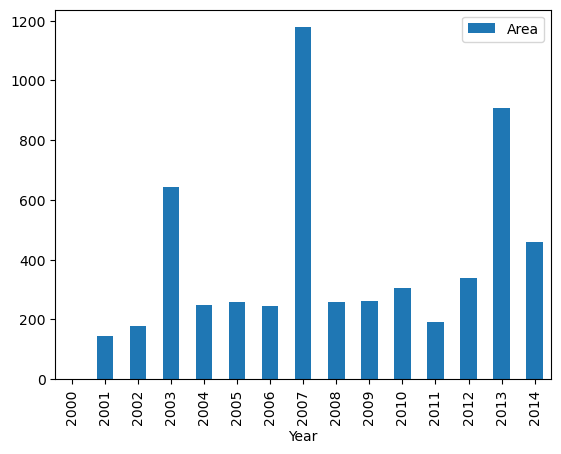

In [21]:
class_areas.plot(x ='Year', y='Area', kind = 'bar')

<div class="alert alert-block alert-danger"> 

### Exercise 2

- Select other regions/states in Australia or the whole Australia feature as your ROI and then calculate forest loss for the whole period of data availability (2000-2021) and plot the results. Then, discuss in which year the region shows more forest loss and why? 
- Try to select another country and quantify forest loss and then compare the results with Australia to see in which country were deforestation is a big challenge, why? 
    
    
</div>    

<div class="alert alert-block alert-danger"> 

### Challenge 1

<div class="alert alert-block alert-danger">

- Use the same method to calculate forest gain in each year and then compare the results with forest loss to see how much forest is lost  and gained for the specific year.
    
</div>    

## References
This is where the references go. For exmaple:

* Hansen, M. C., Potapov, P. V., Moore, R., Hancher, M., Turubanova, S. A., Tyukavina, A., ... & Townshend, J. (2013). High-resolution global maps of 21st-century forest cover change. science, 342(6160), 850-853.

* Wu, Q., (2020). geemap: A Python package for interactive mapping with Google Earth Engine. The Journal of Open Source Software, 5(51), 2305. https://doi.org/10.21105/joss.02305

## Additional information

**License:** The code in this notebook was initially created by the team at [Digital Earth Australia](https://github.com/GeoscienceAustralia/dea-notebooks), and has been modified by Abolfazl Abdollahi. The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 

**Contact:** If you need assistance, please post a question on the ENGN3903 Wattle (**check**) site 

**Last modified:** August 2022